In [ ]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["erddapy"]
_colab_install_missing_deps(deps)

# Interpolating data remotely with ERDDAP

Created: 2021-10-25

Modified: 2023-09-13

ERDDAP servers can do a lot on the server side.
One functionality that can surprise even advanced users is the [ability to interpolate data](https://coastwatch.pfeg.noaa.gov/erddap/convert/interpolate.html).

The API is relatively simple.
We need to provide a table of `"time,longitude,latitude"` we want to interpolate,
a gridded dataset to interpolate from that is served in ERDDAP's griddap,
and the interpolation method.

In this example we will fetch the data for the Saildrone Hurricane Monitoring 2021 NRT data (drone 1031) and interpolate temperature from the Multi-scale Ultra-high Resolution (MUR) SST Analysis to the saildrone track points.

First we need to get the saildrone data:

In [1]:
from pathlib import Path
import pandas as pd
from erddapy import ERDDAP

server = "https://data.pmel.noaa.gov/pmel/erddap"
protocol = "tabledap"
dataset_id = "sd1045_hurricane_2021"

variables = ["latitude", "longitude", "time", "TEMP_SBE37_MEAN"]

e = ERDDAP(server=server, protocol=protocol)
e.dataset_id = dataset_id
e.variables = variables

fname = Path("sd1045_hurricane_2021.csv")
if not fname.exists():
    df = e.to_pandas()
    df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
    df = df.set_index("time (UTC)")
    df = df.dropna()
else:
    df = pd.read_csv(fname, index_col="time (UTC)", parse_dates=True)

Let's take a look at the track data.

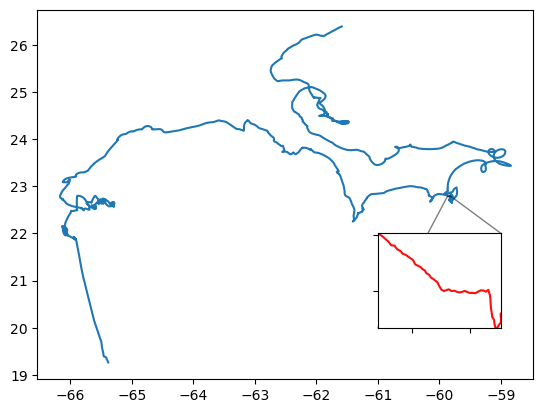

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(
    "longitude (degrees_east)",
    "latitude (degrees_north)",
    data=df,
)

hurricane_video = df.loc["2021-09-30 14"]

xmin, xmax, ymin, ymax = (
    hurricane_video["longitude (degrees_east)"].min(),
    hurricane_video["longitude (degrees_east)"].max(),
    hurricane_video["latitude (degrees_north)"].min(),
    hurricane_video["latitude (degrees_north)"].max(),
)

axins = ax.inset_axes([-61, 20, 2, 2], transform=ax.transData)
axins.plot(
    "longitude (degrees_east)",
    "latitude (degrees_north)",
    color="red",
    alpha=0.95,
    data=hurricane_video,
)

axins.set_xlim(xmin, xmax)
axins.set_ylim(ymin, ymax)
axins.set_xticklabels("")
axins.set_yticklabels("")

ax.indicate_inset_zoom(axins, edgecolor="black");

The inset in the plot shows the data during the recording of [this video](https://www.saildrone.com/news/saildrone-collects-live-video-inside-hurricane-sam). It was the first time a Saildrone was inside a hurricane!

The original data frequency is very high (5 min).
Before we send the interpolation request let's re-sample it to daily data to reduce the number of points.

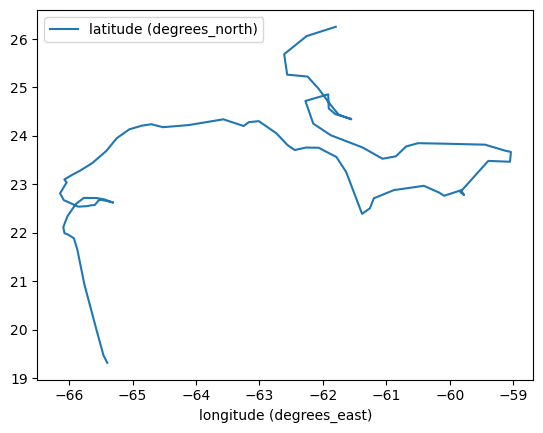

In [3]:
df = df.resample("1D").mean()

df.plot(x="longitude (degrees_east)", y="latitude (degrees_north)");

We need to prepare the data to send to the server. As mentioned above the request will take a table with a header `"time,latitude,longitude"`, then its values. Note that we save a text time column and then rename the columns to create the request.

In [4]:
df["time"] = df.index.strftime("%Y-%m-%dT%H:%M:%SZ")
rdf = df[["time", "latitude (degrees_north)", "longitude (degrees_east)"]]
rdf.columns = ["time", "latitude", "longitude"]

time_lat_lon = rdf.to_csv(index=False)

The cell below builds the request and download get it back as a pandas dataframe.

In [5]:
from urllib.parse import quote_plus

# See https://coastwatch.pfeg.noaa.gov/erddap/convert/interpolate.html
# for more info on the options available
response = "csv"
dataset_id = "jplMURSST41"
variable = "analysed_sst"
algorithm = "Bilinear"
nearby = 4

url = (
    "https://coastwatch.pfeg.noaa.gov/erddap/"
    f"convert/interpolate.{response}?"
    f"TimeLatLonTable={quote_plus(time_lat_lon)}"
    f"&requestCSV={dataset_id}/{variable}/{algorithm}/{nearby}"
)


idf = pd.read_csv(url)

Now we have a new dataframe with interpolated values! Let's add a column with the saildrone data, drop NaNs, and make a few simple comparisons.

In [6]:
idf["saildrone"] = df["TEMP_SBE37_MEAN (degree_C)"].values
idf["diff"] = idf["saildrone"] - idf["jplMURSST41_analysed_sst_Bilinear_4"]

idf.dropna(inplace=True)
idf.set_index("time", inplace=True)

idf.index = pd.to_datetime(idf.index)

First we can check the spread of the differences with a scatter plot.
In an ideal world the both data would match perfectly and fall in the diagonal line.
However, we cannot expect such a perfect fit when comparing sensor from such different instruments and techniques.

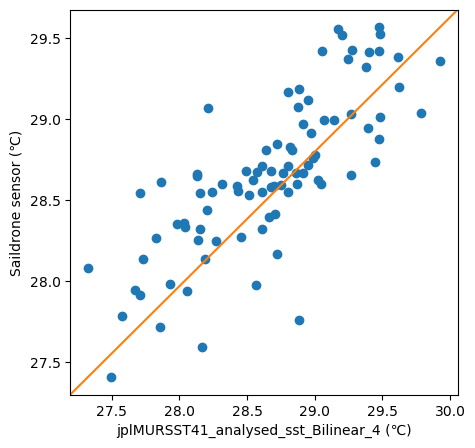

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(idf["jplMURSST41_analysed_sst_Bilinear_4"], idf["saildrone"], "o")
ax.set_xlabel("jplMURSST41_analysed_sst_Bilinear_4 (℃)")
ax.set_ylabel("Saildrone sensor (℃)")
ax.plot([0, 1], [0, 1], transform=ax.transAxes);

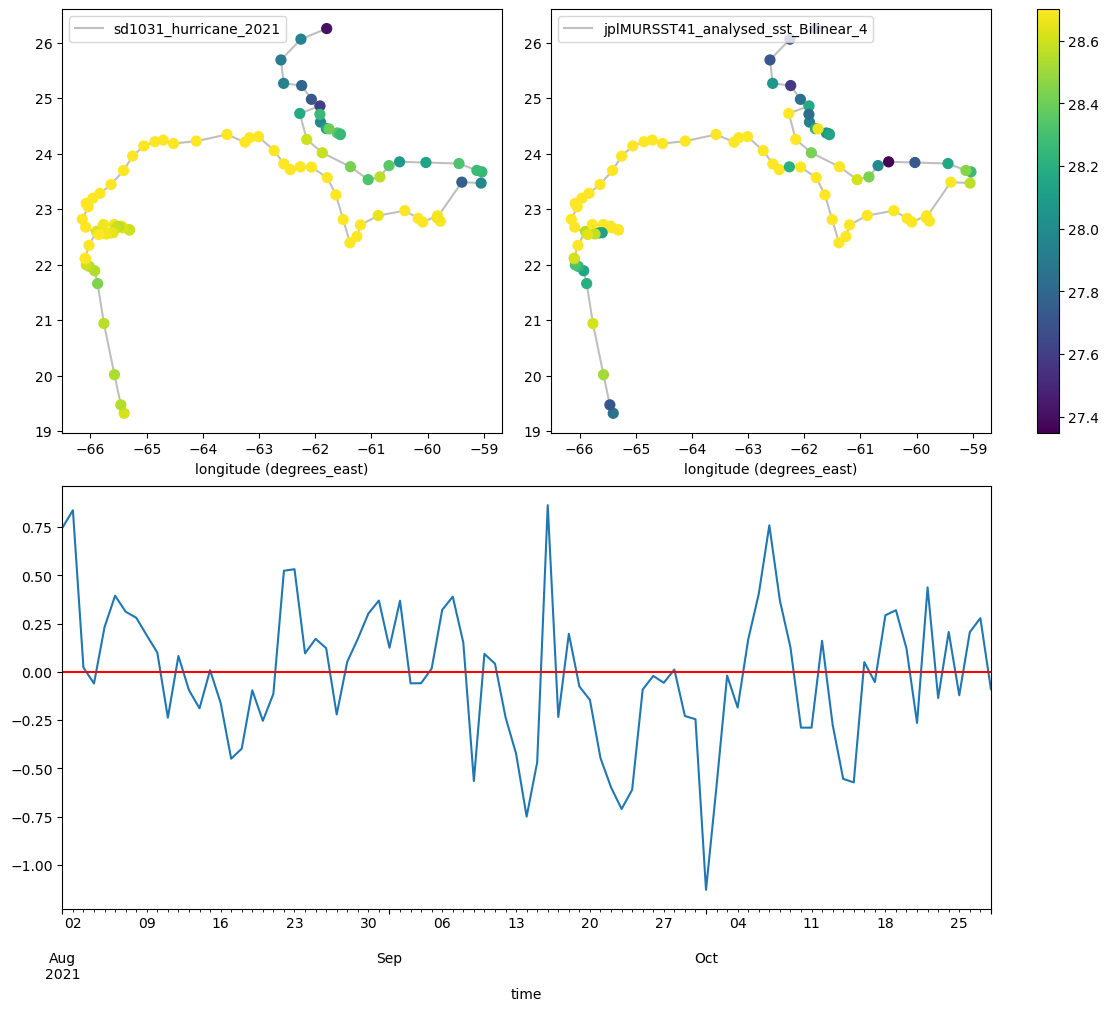

In [8]:
size = 50
kw = {
    "x": "longitude (degrees_east)",
    "y": "latitude (degrees_north)",
    "color": "black",
    "alpha": 0.25,
    "zorder": 1,
}

fig = plt.figure(
    constrained_layout=True,
    figsize=(11, 10),
)

axes = fig.subplot_mosaic(
    """
    AB
    CC
    """
)

vmin, vmax = 27.35, 28.7

cs0 = axes["A"].scatter(
    idf["longitude"],
    idf["latitude"],
    c=idf["saildrone"],
    s=size,
    vmin=vmin,
    vmax=vmax,
    zorder=2,
)
df.plot(ax=axes["A"], label="sd1031_hurricane_2021", **kw).legend(loc="upper left")

cs1 = axes["B"].scatter(
    idf["longitude"],
    idf["latitude"],
    c=idf["jplMURSST41_analysed_sst_Bilinear_4"],
    s=size,
    vmin=vmin,
    vmax=vmax,
    zorder=2,
)
df.plot(ax=axes["B"], label="jplMURSST41_analysed_sst_Bilinear_4", **kw).legend(
    loc="upper left"
)

idf["diff"].plot(ax=axes["C"])
axes["C"].axhline(y=0, color="red")
fig.colorbar(cs0, ax=[axes["A"], axes["B"]], location="right");

We don't have enough for a meaningful analysis here but it looks like the saildrone sensor has higher temperatures than the gridded dataset.